**1. Spark cluster load data từ database như nào?**

- Nếu file nhỏ thì load bình thường không cần chia partition.

- Nếu file lớn như bảng admissions thì phải chia thành partition để tận dụng khả năng load song song của spark cluster. Ví dụ:

In [ ]:
            "admissions": {
                "partition_column": "hadm_id",
                "partition_bounds": (20000000, 30000000),
                "num_partitions": 10,
                "fetch_size": "50000"
            },

- Giải thích:
  - patition_column: cột để chia partition.
  - Khoảng giá trị min/max của cột hadm_id
  - num_partitions: số partition được seperate ra

- Cụ thể:
  - Như ví dụ trên, cột hadm_id có miền giá trị nằm trong khoảng (20 triệu - 30 triệu) => Range = 10 triệu.
  - Chia thành 10 partition thì mỗi partition sẽ tương ứng với khoảng 100000 dòng.
    - Partition 1: 20 triệu <= hadm_id < 21 triệu
    - Partition 2: 21 triệu <= hadm_id < 22 triệu
    - ...
    - Partition 10: 29 triệu <= hadm_id <= 30 triệu
  - Sau đó spark sẽ sinh ra 10 query song song kiểu:
    - SELECT * FROM admissions
      WHERE hadm_id >= 20000000 AND hadm_id < 21000000;
    - SELECT * FROM admissions
      WHERE hadm_id >= 21000000 AND hadm_id < 22000000;
    - ...

    -> Mỗi query được coi là 1 task và được gắn cho 1 core trong 1 spark worker node. Core này sẽ đảm nhiệm vai trò hoàn thành task này.

**2. Nếu chỉ có 3 spark worker mà có đến 10 partition thì sao?**

- Đầu tiên, cần biết mỗi spark worker có bao nhiêu core. Giả sử, mỗi worker có 2 cores thì tổng số core sẽ là 6.
- 10 partition sẽ được chia thành 10 task.

=> **Spark cluster sẽ phân phối như sau:**
  - Lập lịch để thực thi 10 task này: 6 tasks đầu phân cho 6 cores thực thi trước -> sau đó, cái nào xong trước thì sẽ được phân task cho thực hiện tiếp đến khi hết task thì thôi.

**3. Nên chia số lượng partition như nào cho hợp lý**:

- Nếu bảng quá nhỏ không cần chia task.


- Nếu bảng lớn (tính bằng GB trở lên):
  - Số lượng partition (khuyển nghị) = 3-5 x số core. Ví dụ: có 6 core thì nên chia ít nhất là 18 tasks. Lý do: Để Spark có thể lập lịch, thực hiện từ 3-5 lượt là đẹp.

  ! Không nên chia ra quá nhiều partition, vì:
    - Công sức thằng spark-master nó quản lý, phân phối task cũng quá tội.
    - Số lượt đọc/ghi nhiều hơn (đọc/ghi rất tốn time)
    - 1 số trường hợp cần tách ra rồi ghép lại (map/reduce) thì cũng phức tạp, tốn tài nguyên hơn.  
    
  ! Nhưng cũng không nên chia ra quá ít partition, vì:
    - Sẽ lãng phí thời gian và năng lực tính toán. Ví dụ: Có 6 cores nhưng mà chỉ có 2 partitions, thì tức là có 2 cores làm việc thôi còn 4 cores sẽ ngồi chơi (như vậy sẽ không tận dụng được 4 thằng này để làm giảm thời gian)

**4. Postgres nhận cùng lúc 6-10 query (hoặc nhiều hơn) từ các spark worker thì nó có bị bottle neck không?**

- PostgreSQL không biết gì về Spark, nó chỉ thấy có 10 client connections (từ Spark executors) gửi query song song -> Nên nó sẽ tạo 10 luồng để đáp ứng nhu cầu của 10 connection này **(miễn là máy đủ tài nguyên)**.

- Nếu không đủ tài nguyên thì các query sẽ tranh nhau CPU/RAM/I/O... (cái này trong môn Vi xử lý ở đại học có dạy, lúc nào đọc lại)

**👉 Nói nôm na: song song ở Spark → song song ở PostgreSQL, miễn là server chịu nổi.**

**5. Cách chọn partitionColumn như nào?**

- **Không phải cột nào cũng chọn làm partitionColumn được, cần ít nhất 3 tiêu chí:**
  - **Nên là dạng Numeric hoặc Date/Timestamp**: vì cần chia khoảng.
  - **Phân bố đều là tốt nhất (ít Null càng tốt) tránh partition bị lệch**. Ví dụ: Giả sử, cột hadm_id ở trên đa số bản ghi có hadm_id nằm trong khoảng 25 - 26 triệu, các khoảng còn lại có rất ít bản ghi. Thì sẽ có 1 thằng cores được giao task đọc các bản ghi có hadm_id nằm trong khoảng 25-26 triệu sẽ phải đọc cật lực, đọc rất lâu. Trong khi các thằng cores khác làm xong việc từ lâu, ngồi chơi rồi => Không tối ưu.
  - **Ít lặp giá trị**: Thử tưởng tượng dùng 1 cột flag chỉ có giá trị 0, 1 để chia partition đã thấy nó dở hơi rồi. Chả chia ra được bao nhiêu partition cả.

**=> Thường chọn các cột ID, hoặc các cột liên quan đến Date/Time**

**6. Mỗi partition cũng tương ứng với 1 cái file .parquet nhỏ đúng không?**

- **Đúng luôn :)))** Nếu có 10 partition -> 10 task được gán cho Spark -> Spark xử lý 1 task (hay 1 partition) xong thì sẽ ghi luôn nó thành 1 file .parquet nhỏ.
- **Tóm lại: số partition = số parquet (kiểu có bảng admissions chia thành 10 partitions thì đọc/ghi 1 hồi thì sẽ tạo ra 10 file .parquet**

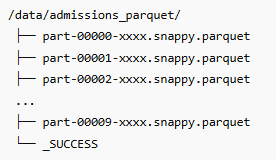

=> **Cái việc chia partition theo khoảng rồi ghi thành parquet như này có 1 lợi ích siêu to lớn. Đó là, các file .parquet được tạo ra bản thân nó cũng đã được partition.**
  - Ví dụ, nếu có cần 1 bản ghi có hadm_id nằm trong khoảng 21-22 triệu thì chỉ cần đọc đúng file part-00001-xxxx-.snapy.parquet lên và tìm trong đó là được. Tiết kiệm rất nhiều tài nguyên máy (I/O/RAM/Bus), lại còn siêu tiết kiệm thời gian.
  - Về phần làm sao biết được file .parquet này là chứa dữ liệu tương ứng với khoảng giá trị nào, thì yên tâm metadata của file parquet to nó có lưu lại thông tin min/max value của mỗi khoảng rồi.

**7. Còn fetch_size thì sao, nó là gì và dựa vào đâu để định giá trị cho nó?**

- **Postgres không thể đọc data từ disk rồi chuyển cho Spark luôn được**, mà nó cần phải load lên RAM trước, xong mới chuyển sang cho Spark.

- **Vì sao lại phải load lên RAM trước?** Lý do là, nó cần phải áp dụng filter, join, index scan,... kiểu như là phải lọc dữ liệu theo điều kiện where lên RAM trước, rồi dữ liệu đó mới stream sang cho Spark được.

- **Vấn đề xảy là ở đây là**: Đôi khi partition khá to, to hơn cả RAM **mức RAM có thể xử lý tốt**, do đó, cần phải chia thành đơn vị nhỏ hơn là các FETCH để load từ DISK lên RAM rồi stream sang cho Spark thông qua các connection.

**! Lưu ý**: Fetch_size không tính bằng byte mà tính bằng số record, ví du: fetch_size = 10000. Tức là mỗi fetch sẽ gồm 10000 dòng (records)

  - Spark worker **không chờ đến khi gom đủ fetch để thành 1 partition rồi mới xử lý**, mà mỗi Fetch nó nhận được thì nó **xử lý ngay lập tức**.
  - Thế nên, về bản chất, là các Spark Worker Core xử lý từng fetch, chứ không phải xử lý cả partition cùng lúc.
  - Partition là **giới hạn về mặt logic** thôi, nó giúp đảm bảo:
    + 2 cores khác nhau không được load các fetch của cùng 1 Partition.
    + Mỗi cores xử lý 1 Partition rồi lưu thành .parquet thì .parquet mới giữ được cái khoảng [min, max] tương ứng với khoảng [min, max] của partition ban đầu => Từ đó, mới tìm kiếm được nhanh hơn.
    + Cố định được size mỗi Partition, Partition khai báo gồm những bản ghi nào thì chắc chắn chỉ lấy những bản ghi đó. Còn fetch thì kích thước mỗi fetch hên xui, tuy là có khai báo fetch_size = 10000, nhưng có khi fetch chỉ gồm 9800 dòng, nó tùy thuộc vào RAM khả dụng của Postgres Server. **Tóm lại, fetch_size chỉ là số dòng tối đa của 1 fetch, còn kích thước thì mỗi fetch lại khác nhau.**

Hình ảnh ví dụ:
  - 1 Table chia làm 3 Partitions
  - Mỗi Partition chia làm nhiều Fetch
  - Các Fetch của các Partition khác nhau được load lên RAM, rồi Spark Master điều phối các Fetch này tới các Spark Worker để xử lý (**quá trình này là song song - tức là 3 fetch được load lên RAM cùng lúc và được xử lý cùng lúc như trong [hình này](https://viewer.diagrams.net/?tags=%7B%7D&lightbox=1&highlight=0000ff&edit=_blank&layers=1&nav=1&title=Spark%20load%20data&dark=auto#R%3Cmxfile%3E%3Cdiagram%20name%3D%22Page-1%22%20id%3D%22S0jMb7JeiJRpv8ubw-wW%22%3E7VtZe6I8FP41XnYeduES3GpbrdWitXcsERiRUBZFf%2F2XsKggrdpx6cxnL1pykpPlvGcNtELXZlHLU1yzA3VgVyhCjyp0vUJRNMux6A%2BmLBMKSQksn5AMz9JT4oYwsFYgJRIpNbR04OcGBhDageXmiRp0HKAFOZrieXCRHzaBdn5VVzHADmGgKfYudWTpgZlQeZYgNh33wDLMbGmSyLpmSjY8JfimosPFFoluVOiaB2GQPM2iGrCxADPJJHzNT3rXW%2FOAExzC8MQOujLDfPB3Xm319vD7wzGXd%2Bksc8UO0yOnmw2WmQw8GDo6wJMQFVpamFYABq6i4d4Fwh3RzGBmoxaJHieWbdegDb2Yl55MNPSD6H7gwSnY6qE5WqDRpFK6AeAFIPr0ZORaXkjZAJyBwFuiIdFar1IZp4pWTZuLDWYUn9LMbbjYlKikemKs594IEj2ksjxGrmWC5ewAiwiiUyFdTESIqB8hVgGpBkPPAh7q6oLFhoyeDPy3CQLNRJ1kNg%2FaVzJV0v8FbuRPxY0m87iRZAlwTAlw1Nlwo86FG%2FUv48ZcHTf6XLg5%2FzJuwtVxq%2B4PQChwuvjRmsXRWsIysFCMflJUYPegbwUWdFC%2FCoMAztAAG3dIijY1YkwyaepgooQxlNkMom0ZmDOAGB7Fd5McYmJFGEcpXlDMqERGwVMpgVKhxaRJNV3HqFA1ayg99xfEY8uAIvrpDmSzIRvoqRa3H2riGP2RGhVKqlbrmCS%2BdQd9oi16PqNxL5jQd15kUkIs0e%2FFnB%2B%2FyDGn1jDftYUo1v0OaiJeTZ9%2FtDBDoz2Q%2B9Kwbvaqekew%2FIeXZls1BYZBu5q2Lctsi9NIJs130EXLes1l05P91bT%2BIMieVScbU7l7H70%2BKp1VV5Dluh%2BpPaduaM%2FieADaPaHXeKwKyESaEP%2FSCe5x8NgJB70OPnTos67YHA6nytjVhzQ9suk3t2U%2FDocjgXRkHbyzr7Ylo6FziCCVhtKgSYYhObX6fXs2fFZYt4Xp5Ii0oV43gDPQH1B7zgJy6M31V3fyFI2ce4a8H41mBNViyWeXn%2FBzBTytQn1l%2B76N9FKaydHoyQx6Teb1oT0VO%2F2oWh%2BI5Ag2X6R%2Bsy6O6y4zNJetBdVeGLUHt%2FcwRnviAKGFulrV1KlpdfseMbMmPfb3M%2Bqqzl%2FUl8CiAEu1Opz65gljGJlhE3kJ6Umq0tG7QK4YqbtSw977hx54MZbiQB4%2B9x%2FZ2rjdxop7LSNnCCFv5CXZEEPt2rhwJhOnuX2ueWPrmRPGHXd%2BXA6IOOdh3ChxzWsnfbQ%2F7ynI5mNPcUQOhWAI8o5bSV2GhuBAi%2B36kpml65i9NALkc%2BkrBQE%2BHwT4XfUgiZIYQJ8rBtAHxIC%2FsAhZC%2Bx6VQjN36qQ47Oi0vLxolkRLdyqkONxo4lr45YtdqtCjsKNvTpuB1yD3aqQWxVyq0K%2BXYXQJdnQJauQbK1bFfIzqxCq5ArxsmUIU3aF%2BPeXIXTZHd9lyxAcB25lyLFpEVNWP142LWJvZcg3cOOujtveG7dbGbKLG3v1l4%2FM7WXIrQy5lSHnLEOYkmzoomXI3hvZWxlyzTKEKblDvGwZwp4w6TpAmdgdZUrQR1h5UzSgo%2FgY2kuEfV4D5YirPMuwxGkQp%2BhqofAk2V%2FsLuZUWYVEM9nQ08N%2Bgreku1ge7Rj6YgeDDmYQn%2Bkw0LOUxPWgBnx%2FP%2FDqOht5DgPbckC5Qugs4HWmTCF4SqU57kQugGcKCpHNsaUO61wxpw5nixLsUW9EDzC1RILZJ6xUKutRdhgsZFPRzNADLcxa5zcE0THiJVExmEfIgRg4yZ%2FGtUGyjuEpuoUEXxhzCpgoNg%2FTXcmFkUAKuzBx5Nlc9QmCufDnNputqa6jO%2FQDwwM%2BYqij3FxVfJSXEwPgzXOeXC1OcKihJ3mADkPVzkz3Txw%2FiH%2FOnwpyBQWiSlJBtsTOuXPpD3fAayfg6CL%2BkB2XdDbUpljwim%2BuRY36mxZeNk6iUCv9iJ6k8jLPJ1sgsoK3bAb0PMb0X2zaqkdbw%2BrL9dzozG%2FbjS0u3Nywxa2MD2%2B3pwQoi3Biz0IR2LtMbLgQHVQzpvUquUYZ6Dvf5BcwRgJCFpEaydffXweKZ4DgKwzYcq3ZzgUyBfCAjbY7z%2B%2BuTCvS6XrQir3AOtIInySb2RzJsVK2jXLtzEQR7J6ZknPvzIRUSVluDXPxAP%2BrLReDI0d8vTOSPZKBKX42k2dAD8mmN2a2RukPLO%2BAu%2F6b5X3L8rJvjvZbHnc5y%2BMKST9dLN8OtTxSoPIzsdl591jeyTS37F3Kj9XcwzXwuzp%2BQs3NXlPt19zq5TS3ShQ8ffW7mssXZqKLec25YkZWPH0eM45lKNbwexmKQabAcKYgs%2Fcm5yJ3fdlNzgJ603jUhV6aAq78NkevCipxqtscrpDUCyVXOWXvcLhz3eNwP%2BNr9%2F8V6FTJB4QXRr3swuaG%2BllRL72qPxHqqLn5x%2BwkHmz%2BxZ1u%2FAc%3D%3C%2Fdiagram%3E%3C%2Fmxfile%3E)**)